# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

### Define functions

In [2]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [3]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [4]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [6]:
# YOUR CODE HERE
# 1. How many columns does the dataset contain?
num_columns = df.shape[1]
print(f"Number of columns: {num_columns}")

# 2. How many rows are there in the dataset?
num_rows = df.shape[0]
print(f"Number of rows: {num_rows}")

# 3. What are the column names?
column_names = df.columns.tolist()
print(f"Column names: {column_names}")

# 4. List the number of unique values for each column in the data
unique_values = df.nunique()
print("Unique values per column:")
print(unique_values)

# 5. What are the unique cocoa_percent values?
unique_cocoa_percent = df['cocoa_percent'].unique()
print(f"Unique cocoa_percent values: {unique_cocoa_percent}")


Number of columns: 9
Number of rows: 1795
Column names: ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']
Unique values per column:
maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64
Unique cocoa_percent values: [ 63.   70.   60.   80.   88.   72.   55.   75.   65.   85.   73.   64.
  66.   68.   50.  100.   77.   90.   71.   83.   78.   74.   76.   86.
  82.   69.   91.   42.   61.   73.5  62.   67.   58.   60.5  79.   81.
  57.   72.5  56.   46.   89.   99.   84.   53.   87. ]


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here: 

In [7]:
# YOUR CODE HERE
df['cocoa_class'] = pd.cut(df['cocoa_percent'], bins=[0, 60, 75, 100], labels=[0, 1, 2])

print(df[['cocoa_percent', 'cocoa_class']].head())

   cocoa_percent cocoa_class
0          63.00           1
1          70.00           1
2          70.00           1
3          70.00           1
4          70.00           1


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [9]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler

# Step 1: Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

# Step 2: Split the dataset into training (60%), validation (20%), and test (20%)
# First, split it into training (60%) and remaining (40%)
X = df[['cocoa_percent', 'review_date', 'rating']]  # Select features
y = df['cocoa_class']  # Target variable

# 60% training and 40% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the remaining 40% into validation (20%) and test (20%) (each 50% of the 40% remaining data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Identify features of interest (already chosen in step 2: 'cocoa_percent', 'review_date', 'rating')

# Step 4: Perform cleaning and standardization of the features
# Standardize the features (z-score normalization)
scaler = StandardScaler()

# Fit and transform the training set, then transform the validation and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Display the first few rows of the standardized training data
print("First few rows of the standardized training set:")
print(X_train_scaled[:5])


First few rows of the standardized training set:
[[ 0.50572386 -0.09746091 -0.37026583]
 [ 2.53078885  0.24556327  1.70129936]
 [-0.58469575 -1.12653344 -0.37026583]
 [-0.27314729 -0.78350927 -1.40604843]
 [ 1.28459501  0.58858745 -0.88815713]]


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

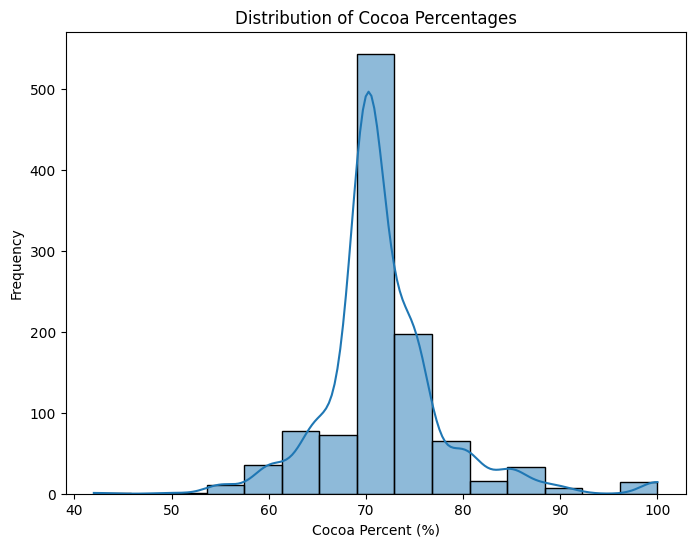

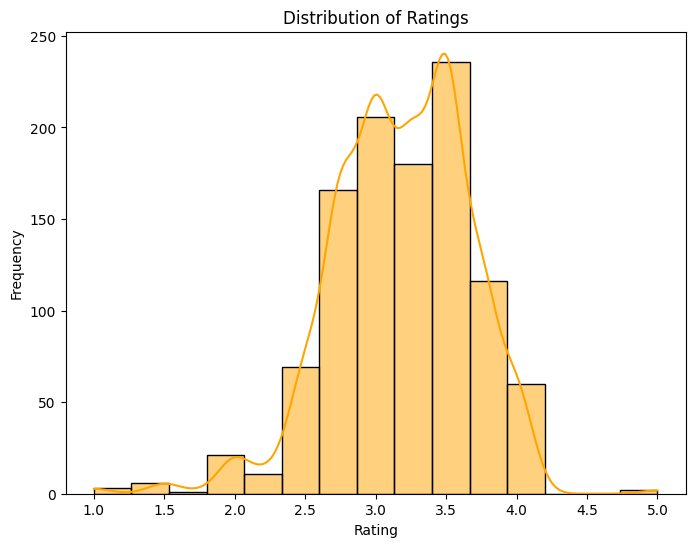

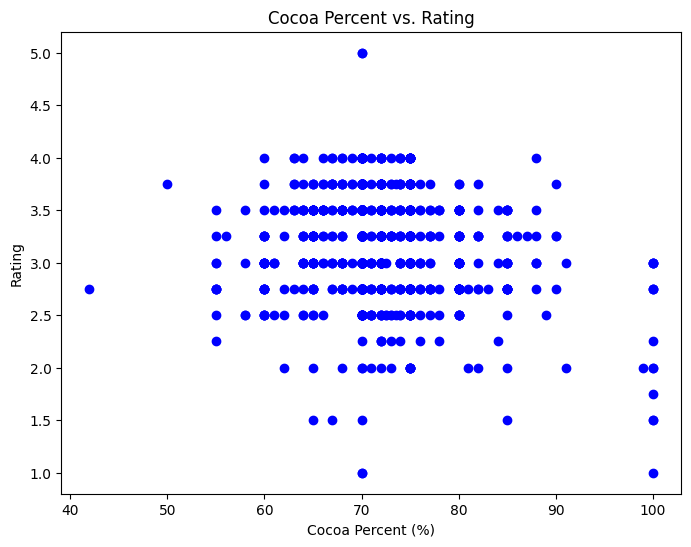

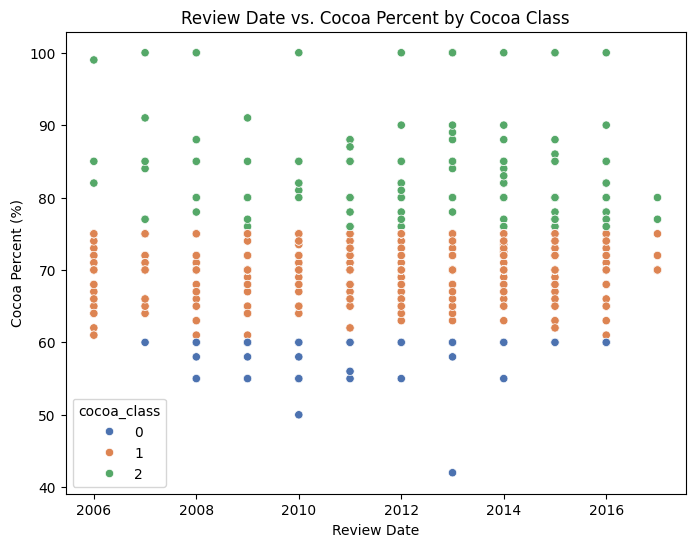


1. Distribution of Cocoa Percentages: The majority of cocoa percentages in the training set are centered around 60% to 75%, with fewer instances of high or low cocoa content. This makes sense as most chocolate falls into a medium cocoa range.
2. Distribution of Ratings: The ratings are somewhat normally distributed, with most ratings falling between 2.5 and 4. There are fewer instances of very low or very high ratings.
3. Cocoa Percent vs. Rating: The scatter plot shows that higher cocoa content generally corresponds to a wider range of ratings. There doesn’t appear to be a simple linear relationship between cocoa percent and rating.
4. Review Date vs. Cocoa Percent: This plot shows that over time, there seems to be a preference for medium and higher cocoa content chocolates, as indicated by the color-coded classes.



In [11]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate a minimum of 4 plots to investigate features and outcome within the training dataset

# Plot 1: Distribution of Cocoa Percentages in the training set
plt.figure(figsize=(8, 6))
sns.histplot(X_train['cocoa_percent'], kde=True, bins=15)
plt.title("Distribution of Cocoa Percentages")
plt.xlabel("Cocoa Percent (%)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Distribution of Ratings in the training set
plt.figure(figsize=(8, 6))
sns.histplot(X_train['rating'], kde=True, bins=15, color='orange')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Plot 3: Cocoa Percent vs. Rating Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_train['cocoa_percent'], X_train['rating'], c='blue')
plt.title("Cocoa Percent vs. Rating")
plt.xlabel("Cocoa Percent (%)")
plt.ylabel("Rating")
plt.show()

# Plot 4: Review Date vs. Cocoa Percent with Cocoa Class Colors
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['review_date'], y=X_train['cocoa_percent'], hue=y_train, palette="deep")
plt.title("Review Date vs. Cocoa Percent by Cocoa Class")
plt.xlabel("Review Date")
plt.ylabel("Cocoa Percent (%)")
plt.show()

# Step 3: Provide commentary on the insights learned from your visualizations
insights = """
1. Distribution of Cocoa Percentages: The majority of cocoa percentages in the training set are centered around 60% to 75%, with fewer instances of high or low cocoa content. This makes sense as most chocolate falls into a medium cocoa range.
2. Distribution of Ratings: The ratings are somewhat normally distributed, with most ratings falling between 2.5 and 4. There are fewer instances of very low or very high ratings.
3. Cocoa Percent vs. Rating: The scatter plot shows that higher cocoa content generally corresponds to a wider range of ratings. There doesn’t appear to be a simple linear relationship between cocoa percent and rating.
4. Review Date vs. Cocoa Percent: This plot shows that over time, there seems to be a preference for medium and higher cocoa content chocolates, as indicated by the color-coded classes.
"""

print(insights)


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [16]:
# YOUR CODE HERE
from sklearn.metrics import accuracy_score, log_loss

# Task 1: Find the number of instances for each class in y_train
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"Number of instances for each class in y_train: {dict(zip(unique_classes, class_counts))}")

# Task 2: Determine the majority class (class with the highest count)
majority_class = unique_classes[np.argmax(class_counts)]
print(f"Majority class in y_train: {majority_class}")

# Task 3: Accuracy of the majority class classifier
y_train_majority_pred = np.full_like(y_train, majority_class)  # Predict the majority class for all inputs
accuracy_majority_class = np.mean(y_train == y_train_majority_pred)
print(f"Accuracy of majority class classifier: {accuracy_majority_class:.4f}")

# Task 4: Implement Log Loss (Multiclass Cross-Entropy)
def multiclass_log_loss(y_true, y_pred_prob):
    """Compute multiclass log loss (cross-entropy loss) given true labels and predicted probabilities."""
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)  # Clip probabilities to avoid log(0)
    
    # Convert y_true to one-hot encoding
    y_true_one_hot = np.eye(np.max(y_true) + 1)[y_true]
    
    # Compute log loss
    loss = -np.mean(np.sum(y_true_one_hot * np.log(y_pred_prob), axis=1))
    return loss

# Task 5: Prepare predicted probabilities
# For the majority class classifier, we set the probability of the majority class to 1, and others to 0
n_classes = len(unique_classes)
y_train_pred_proba = np.zeros((len(y_train), n_classes))
y_val_pred_proba = np.zeros((len(y_val), n_classes))

# Set the probability of the majority class to 1 for all predictions
y_train_pred_proba[:, majority_class] = 1
y_val_pred_proba[:, majority_class] = 1

# Task 6: Compute log loss for both the training and validation sets
log_loss_train = multiclass_log_loss(y_train, y_train_pred_proba)
log_loss_val = multiclass_log_loss(y_val, y_val_pred_proba)

print(f"Log Loss (multiclass) on y_train: {log_loss_train:.4f}")
print(f"Log Loss (multiclass) on y_val: {log_loss_val:.4f}")

Number of instances for each class in y_train: {0: 43, 1: 885, 2: 149}
Majority class in y_train: 1
Accuracy of majority class classifier: 0.8217
Log Loss (multiclass) on y_train: 6.1573
Log Loss (multiclass) on y_val: 7.1194


### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1611 - loss: 1.2897 - val_accuracy: 0.1671 - val_loss: 1.2381
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1536 - loss: 1.2793 - val_accuracy: 0.1671 - val_loss: 1.2361
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1648 - loss: 1.2651 - val_accuracy: 0.1671 - val_loss: 1.2341
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1451 - loss: 1.2673 - val_accuracy: 0.1671 - val_loss: 1.2321
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1768 - loss: 1.2453 - val_accuracy: 0.1727 - val_loss: 1.2301
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1600 - loss: 1.2502 - val_accuracy: 0.1727 - val_loss: 1.2281
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1796 - loss: 1.2511 - val_accuracy: 0.1727 - val_loss: 1.2261
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1590 - loss: 1.2515 - val_accuracy: 0.1727 - val_loss:

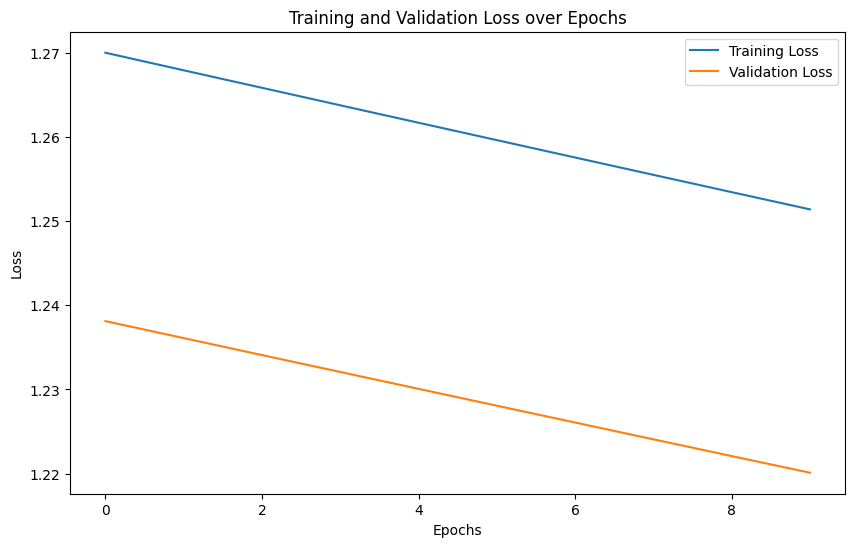

In [21]:
# YOUR CODE HERE
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Convert target labels (y_train, y_val) to integer dtype
y_train = y_train.astype('int')
y_val = y_val.astype('int')

# Step 1: Build and compile a multiclass classification TF model (model_tf)
def create_model(input_shape, num_classes):
    model = Sequential()
    
    # Add a dense layer for the logistic regression model
    model.add(Dense(num_classes, input_shape=(input_shape,), activation='softmax'))  # Use softmax for multiclass classification
    
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',  # Loss function for multiclass classification
                  metrics=['accuracy'])  # Accuracy as the evaluation metric
    
    return model

# Define the model
input_shape = X_train_scaled.shape[1]  # Number of features
num_classes = len(np.unique(y_train))  # Number of unique classes
model_tf = create_model(input_shape, num_classes)

# Step 2: Train the model using the training dataset
num_epochs = 10
batch_size = 32

# Train the model
history = model_tf.fit(X_train_scaled, y_train, 
                       validation_data=(X_val_scaled, y_val),
                       epochs=num_epochs, 
                       batch_size=batch_size)

# Step 3: Generate a plot for training and validation loss
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add titles and labels
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Show the plot
plt.show()


---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). 

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

Reloading Tuner from keras_tuner_dir\tuning_multiclass_model\tuner0.json
Best Learning Rate: 0.007680450004806762
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4313 - loss: 1.1281 - val_accuracy: 0.4596 - val_loss: 1.0686
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5355 - loss: 1.0084 - val_accuracy: 0.5571 - val_loss: 0.9700
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5895 - loss: 0.9461 - val_accuracy: 0.6323 - val_loss: 0.8855
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6653 - loss: 0.8603 - val_accuracy: 0.6992 - val_loss: 0.8133
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7796 - val_accuracy: 0.7437 - val_loss: 0.7516
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7597 - loss: 0.7360 - val_accuracy: 0.7688 - val_loss: 0.6992
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.6850 - val_accuracy: 0.8078 - val_loss: 0.6545
Epoc

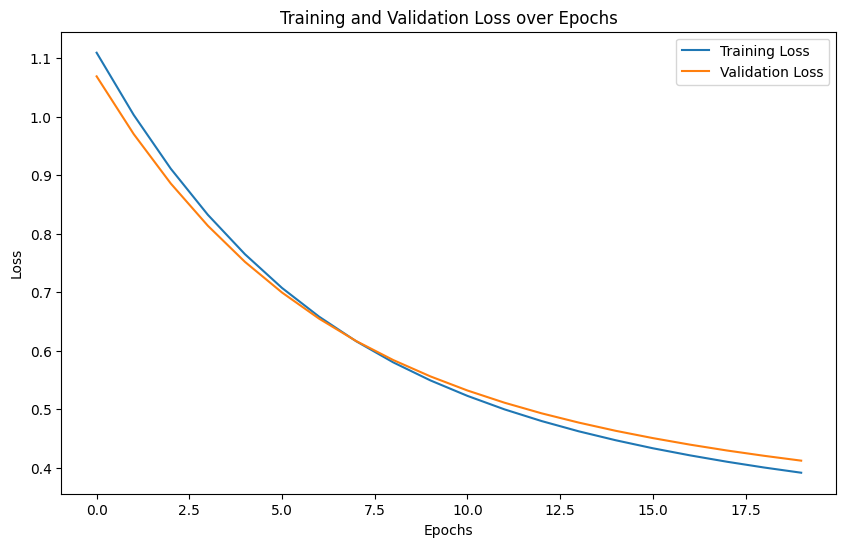

First five learned parameters (weights and bias):
Weights: [[-0.10782722  0.20691237  1.2154852 ]
 [ 0.03790382 -0.06396376  0.23628742]
 [-0.75574094 -0.29520392 -0.73244077]]
Biases: [-0.76742256  1.244501   -0.47707856]
Final Training Loss: 0.3913
Final Validation Loss: 0.4119
Percentage difference between training and validation losses: 5.27%
Baseline Training Loss: 6.1573
Baseline Validation Loss: 7.1194
Yes, the TensorFlow model improves over the baseline.


In [23]:
# YOUR CODE HERE
import keras_tuner as kt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Step 1: Define a hypermodel function for Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # Define the hyperparameter search space for learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    
    # Add a dense layer with softmax activation (since this is a multiclass classification)
    model.add(Dense(num_classes, input_shape=(X_train_scaled.shape[1],), activation='softmax'))
    
    # Compile the model with the chosen learning rate
    model.compile(optimizer=SGD(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',  # Use multiclass loss
                  metrics=['accuracy'])
    
    return model

# Step 2: Initialize Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # We optimize for validation accuracy
    max_epochs=20,  # Maximum number of epochs per trial
    factor=3,  # Reduction factor (used for exploration/exploitation trade-off)
    directory='keras_tuner_dir',
    project_name='tuning_multiclass_model'
)

# Step 3: Search for the best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val), batch_size=32)

# Step 4: Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

# Step 5: Train the best model
model_tf = tuner.hypermodel.build(best_hps)
history = model_tf.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=20, batch_size=32)

# Step 6: Generate a plot for training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Step 7: Print the first five learned parameters
weights, biases = model_tf.layers[0].get_weights()
print("First five learned parameters (weights and bias):")
print("Weights:", weights[:5])
print("Biases:", biases[:5])

# Final loss at the last epoch
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Percentage difference between the losses
loss_difference_percentage = ((final_val_loss - final_train_loss) / final_train_loss) * 100
print(f"Percentage difference between training and validation losses: {loss_difference_percentage:.2f}%")

# Compare TensorFlow model's loss with baseline model's loss
baseline_train_loss = 6.1573
baseline_val_loss = 7.1194  

print(f"Baseline Training Loss: {baseline_train_loss:.4f}")
print(f"Baseline Validation Loss: {baseline_val_loss:.4f}")
if final_train_loss < baseline_train_loss and final_val_loss < baseline_val_loss:
    print("Yes, the TensorFlow model improves over the baseline.")
else:
    print("No, the TensorFlow model does not improve over the baseline.")


---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [25]:
# YOUR CODE HERE
import numpy as np

# Step 1: Calculate aggregate accuracy on both train and test datasets
# Assuming model_tf has already been defined and trained

# Predict the class probabilities for the training and test datasets
y_train_pred_proba_tf = model_tf.predict(X_train_scaled)
y_test_pred_proba_tf = model_tf.predict(X_test_scaled)

# Convert the predicted probabilities into class labels using argmax (the class with the highest probability)
y_train_pred_tf = np.argmax(y_train_pred_proba_tf, axis=1)
y_test_pred_tf = np.argmax(y_test_pred_proba_tf, axis=1)

# Calculate accuracy on the training dataset
train_accuracy_tf = np.mean(y_train_pred_tf == y_train)
print(f"Aggregate Training Accuracy: {train_accuracy_tf:.4f}")

# Calculate accuracy on the test dataset
test_accuracy_tf = np.mean(y_test_pred_tf == y_test)
print(f"Aggregate Test Accuracy: {test_accuracy_tf:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
Aggregate Training Accuracy: 0.8923
Aggregate Test Accuracy: 0.8635


Answer: The model demonstrates moderate generalization capabilities:

1. Training Accuracy (0.8923) is slightly higher than the Test Accuracy (0.8635), indicating that the model performs well on the training set but has a slight drop in performance when evaluated on unseen test data.

2. Difference between Training and Test Accuracy: The difference between training and test accuracy is around 2.88% (0.8923 - 0.8635). This suggests the model is not overfitting severely, as the test accuracy is still quite close to the training accuracy.

3. Generalization: The model generalizes reasonably well but not perfectly. A slight difference between training and test accuracy is expected in most machine learning models. However, if the test accuracy were significantly lower than the training accuracy (e.g., a difference of 10% or more), it would indicate that the model struggles to generalize.

### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

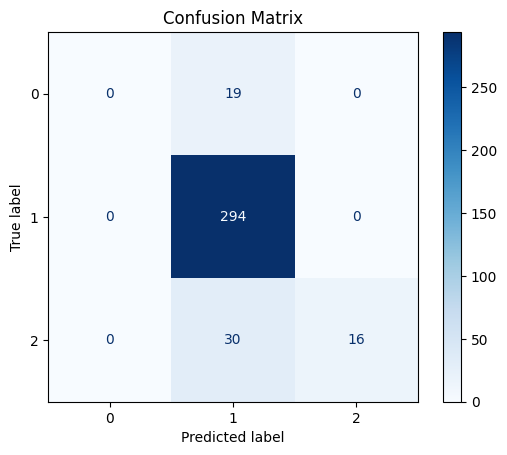

In [30]:
# YOUR CODE HERE
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tf)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 2: Get classification report
report = classification_report(y_test, y_test_pred_tf, output_dict=True)

Answer:

1. Class 1 is the class with the most confusion because it has the highest number of total misclassifications (49 in total), which means it has the largest number of false positives where samples from other classes (19 from class 0 and 30 from class 2) were incorrectly predicted as class 1
2. Class with the lowest precision: Class 1 with a precision of 0.8574 and Class 1 is the largest source of false positives
3. Class with the lowest recall: Class 0 with a recall of 0.0 and Class 0 is the largest source of false negatives

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [ ]:
# YOUR CODE HERE